# BLE Sniffer analysis

This notebook is used to analyze the BLE advertisements that we sniffed from.
Derived from `sniffer-3` which focused on # advertisements observed. This considers the duration observed for normalized to 0 

In [1]:
from builtins import breakpoint
import multiprocessing as mp
import pandas.testing as pdt
from dateutil import parser
import os
import numpy as np
import pandas as pd
import threading
from tqdm import tqdm
import pdb
from sniffer import get_aggregates, parse_json, read_files
from mpl_toolkits import mplot3d
from matplotlib import pyplot as plt
import swifter


In [2]:
def get_time_stats(ndf):
    # Get exposure notification
    ndf["startTime"] = ndf.time.apply(lambda x:np.min(x))
    ndf["endTime"] = ndf.time.apply(lambda x:np.max(x))
    ndf["exposure_s"] = ndf['endTime'] - ndf['startTime']
    ndf["exposure_s"] = ndf.exposure_s.abs()
    return ndf

def reset_starting_index(ndf):
    # Reset all time starting index to 0
    ndf["time"] = ndf.time.apply(lambda x:[x[i]-np.min(x) for i in range(0, len(x))])
    return ndf

def get_intervals(ndf):
    # Get the intervals between advertisement packets
    ndf["intervals"] = ndf.time.apply(lambda x:[x[i]-x[i-1] for i in range(1, len(x))])
    ndf["meanInterval"] = ndf.intervals.apply(lambda x:np.mean(x))
    print('We drop all single MAC occurances here:')
    ndf = ndf[ndf.meanInterval>0]
    print("==> Drop all single advertisements")
    ndf["maxInterval"] = ndf.intervals.apply(lambda x:np.max(x))
    return ndf

In [3]:
INTERVAL = 1000
EXPOSURE = 15

We drop all single MAC occurances here:
==> Drop all single advertisements
No of unique MACs:279


/home/ubuntu/miniconda/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/tmp/ipykernel_13196/3925151284.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ndf["maxInterval"] = ndf.intervals.apply(lambda x:np.max(x))


<Figure size 1080x720 with 0 Axes>

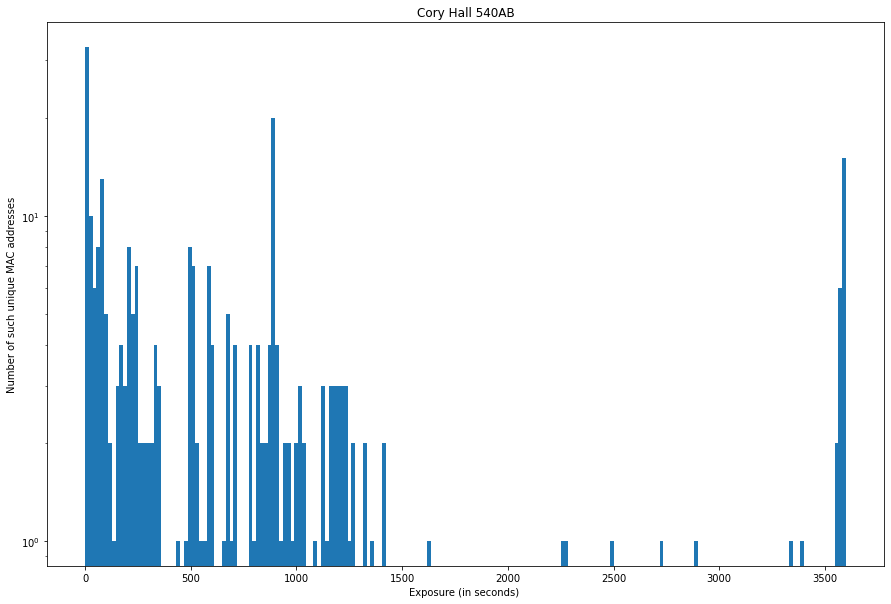

No of unique MACs:279


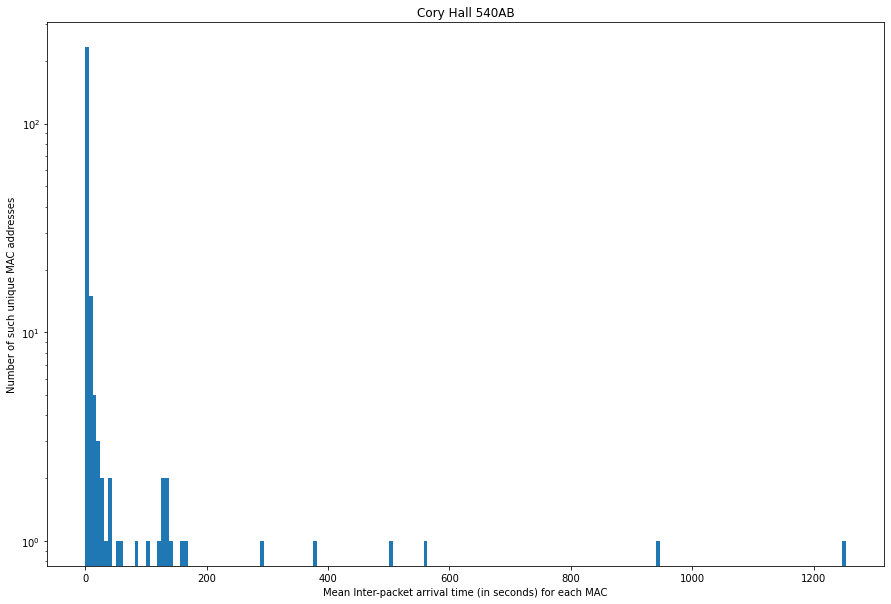

In [4]:
# A single log file from cory_elevator
plt.figure(figsize=(15, 10))
ndf = pd.read_pickle("pkls/solo-540ab-sortedtime.pkl")

ndf = get_intervals(ndf) # Get intervals for a
ndf = get_time_stats(ndf) # Get exposure in seconds



plt.figure(figsize=(15, 10))
plt.hist(ndf.exposure_s, bins=200)
plt.yscale('log')
plt.xlabel("Exposure (in seconds) ")
plt.ylabel("Number of such unique MAC addresses")
print(f"No of unique MACs:{len(ndf)}")
plt.title("Cory Hall 540AB")
plt.show()


plt.figure(figsize=(15, 10))
plt.hist(ndf.meanInterval, bins=200)
plt.xlabel("Mean Inter-packet arrival time (in seconds) for each MAC")
plt.ylabel("Number of such unique MAC addresses")
plt.yscale('log')
# plt.xscale('log')
print(f"No of unique MACs:{len(ndf)}")
plt.title("Cory Hall 540AB")
plt.show()




No of unique MACs post filtering:31
df:5a:e9:b4:51:26, for a total of 6.014999866485596
d9:6d:06:76:a6:a7, for a total of 0.7779998779296875
cc:3d:61:25:3e:12, for a total of 0.46899986267089844
7f:cf:b0:c5:53:94, for a total of 0.18200016021728516
3b:20:aa:3f:71:99, for a total of 10.778000116348267
4b:4f:fd:2a:c7:d2, for a total of 5.245999813079834
07:8a:b9:f2:e9:59, for a total of 9.770000219345093
68:9e:3c:29:64:03, for a total of 10.66700005531311
42:dc:1e:dd:07:c4, for a total of 0.2739999294281006
18:a8:50:cc:e5:57, for a total of 7.771000146865845
7d:5c:d3:08:74:cb, for a total of 12.351999998092651
19:10:e2:01:33:6f, for a total of 12.91599988937378
ee:5d:af:ab:12:e4, for a total of 2.003999948501587
7f:b7:7b:27:e9:ad, for a total of 1.8459999561309814
21:18:c5:cf:bd:db, for a total of 9.835000038146973
61:1c:1b:e9:dc:66, for a total of 0.1940000057220459
e2:11:95:9f:18:7f, for a total of 2.0
58:70:d8:26:a4:e8, for a total of 9.102999925613403
7d:14:35:3b:c9:bf, for a total o

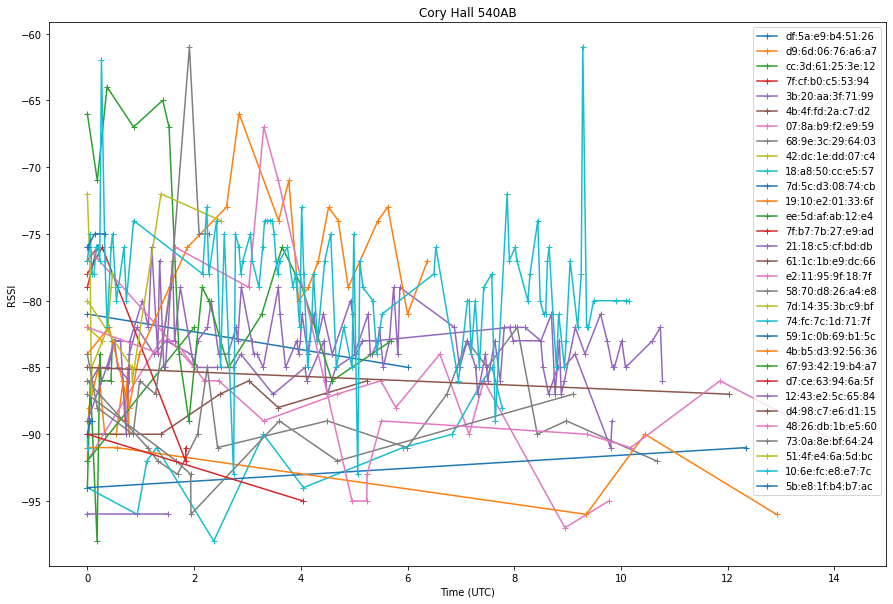

In [5]:
ndf = ndf[(ndf.maxInterval <= INTERVAL)] # Clip the long running flows
ndf = ndf[(ndf.exposure_s <= EXPOSURE)] # Clip the long running flows
ndf = ndf.sort_values(['startTime', 'exposure_s']) # to ensure the graphs have the same axis
# ndf = ndf[:7]
ndf = reset_starting_index(ndf) # Resetting everything to start at T=0

plt.figure(figsize=(15, 10))
print(f"No of unique MACs post filtering:{len(ndf)}")
for index, row in ndf.iterrows():
    plt.plot(row["time"], row["rssi"], label=row["mac"], marker='+')
    print(f"{row.mac}, for a total of {row.exposure_s}")
plt.xlabel("Time (UTC)")
plt.ylabel("RSSI")
plt.legend()
plt.title("Cory Hall 540AB")
plt.show()